In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ratings = pd.read_csv('data/amazon/automotive_ratings.csv')

In [3]:
#How many items are in the data set? How many users? How many ratings?

n_ratings = len(ratings)
n_users = ratings['user'].nunique()
n_items = ratings['item'].nunique()

print(f'Number of ratings: {n_ratings}')
print(f'Number of unique users: {n_users}')
print(f'Number of unique items: {n_items}')



Number of ratings: 20473
Number of unique users: 2928
Number of unique items: 1835


In [4]:
#User activity:
#What is the distribution of ratings-per-user?

user_freq = ratings[['user', 'rating']].groupby('user').count().reset_index()
user_freq.columns = ['user', 'n_ratings']
user_freq.head()

,user,n_ratings
0,A00473363TJ8YSZ3YAGG9,5
1,A0473259F6GQNBD88IYN,11
2,A09567722SXKYZTV7OFCJ,5
3,A10063PJ5C9WQQ,5
4,A100UD67AHFODS,7


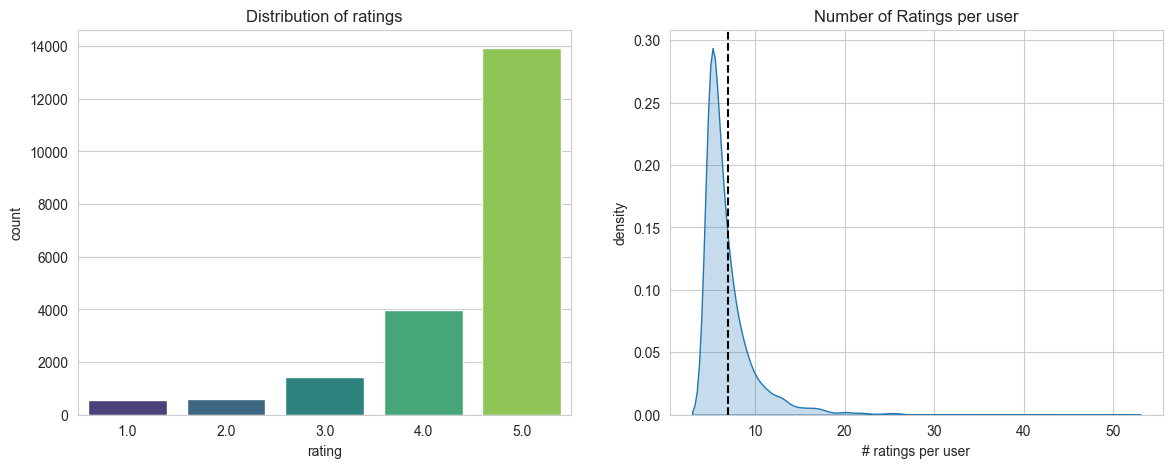

In [5]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], fill=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of Ratings per user")
plt.show()

In [6]:
#Find most and least active users for all 4 dataset. How many ratings did they provide.
user_active = ratings.groupby('user')['rating'].count()

most_active = user_active.idxmax()
least_active = user_active.idxmin()

most_active_ratings = user_active[most_active]
least_active_ratings = user_active[least_active]

print(f"The most active user is {most_active} with {most_active_ratings} ratings.")
print(f"The least active user is {least_active} with {least_active_ratings} ratings.")

The most active user is A2V1J3JT5OOZFO with 51 ratings.
The least active user is A00473363TJ8YSZ3YAGG9 with 5 ratings.


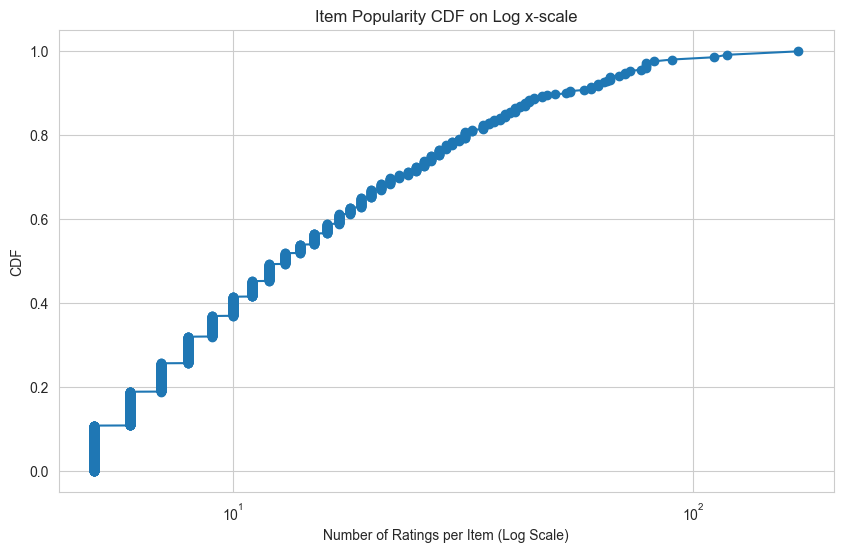

In [7]:
#Item statistics:
#What is the item popularity curve (the distribution of ratings-per-item)? A CDF plot on a log x scale or a rank-frequency plot on a log-log scale.

item_freq = ratings.groupby('item')['rating'].count().reset_index()
item_freq.columns = ['item', 'n_ratings']

item_freq_sort = item_freq.sort_values(by='n_ratings')

cdf = np.cumsum(item_freq_sort['n_ratings']) / np.sum(item_freq_sort['n_ratings'])

plt.figure(figsize=(10, 6))
plt.plot(item_freq_sort['n_ratings'], cdf, marker='o')
plt.xscale('log')
plt.xlabel('Number of Ratings per Item (Log Scale)')
plt.ylabel('CDF')
plt.title('Item Popularity CDF on Log x-scale')
plt.show()


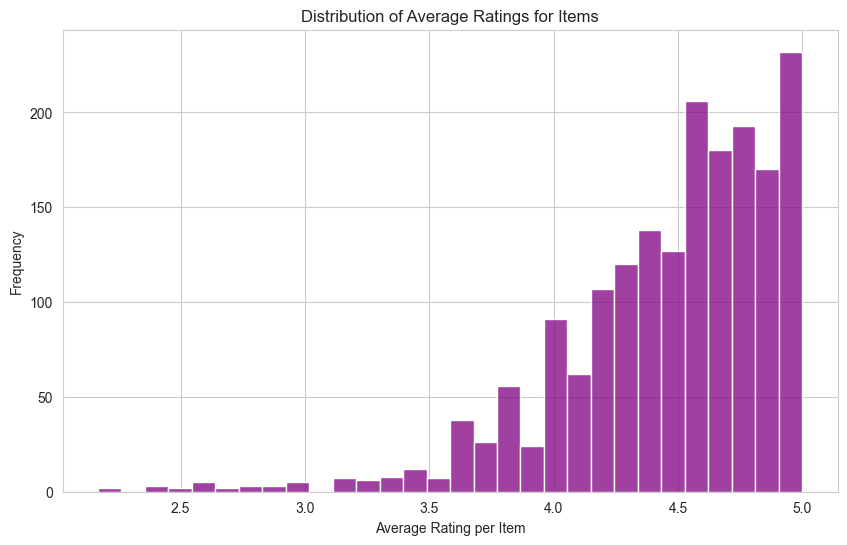

In [8]:
#What is the distribution of average ratings for items?

avg_item_rating = ratings.groupby('item')['rating'].mean().reset_index()
avg_item_rating.columns = ['item', 'avg_rating']

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.histplot(avg_item_rating['avg_rating'], bins=30, kde=False, color='purple')
plt.xlabel('Average Rating per Item')
plt.ylabel('Frequency')
plt.title("Distribution of Average Ratings for Items")
plt.show()


In [9]:
#Non-personalized recommendation
#What are the 10 most popular items (the items with the most ratings)? Show the item ID, item title, and the number of ratings.

item_pop = ratings.groupby('item')['rating'].count().reset_index()
item_pop.columns = ['item', 'n_ratings']

top10_item = item_pop.sort_values(by='n_ratings', ascending=False).head(10)

print('The most popular items based on the number of ratings are: \n')
print(top10_item[['item', 'n_ratings']])


The most popular items based on the number of ratings are: 

            item  n_ratings
477   B000CITK8S        169
1656  B007TG7HFO        118
1089  B001V8U12M        111
1141  B002BC4N5I         90
1198  B002OUMVWY         82
866   B0014Y82UQ         79
705   B000NCOKZQ         79
273   B0009IQZFM         79
177   B00068XCQU         79
1012  B001LHVOVK         77


In [10]:
#What are the 10 items with the highest average ratings (with their titles and average ratings)?

item_avg_rating = ratings.groupby('item')['rating'].mean().reset_index()
item_avg_rating.columns = ['item', 'avg_rating']

top10_avg_rate = item_avg_rating.sort_values(by='avg_rating', ascending=False).head(10)

print('The 10 items with the highest average ratings are: \n')
print(top10_avg_rate)


The 10 items with the highest average ratings are: 

            item  avg_rating
461   B000CB6FNS         5.0
1390  B003YJJS2U         5.0
1381  B003WDDLTO         5.0
829   B0010DZZQA         5.0
599   B000FR5XQE         5.0
828   B0010DZZPG         5.0
600   B000FRLO9Y         5.0
1635  B007B8JMZI         5.0
343   B000B8WCBG         5.0
171   B00067BVDC         5.0


In [11]:
#What are the 10 movies with the highest damped average ratings, with a Bayesian damping factor of 5? Show both the damped and undamped mean for these items. You can also use the bias model (without user biases) to compute these means. The damped mean with factor 
 #is computed by: $r^~i=\frac{\Sum{r_{ui}\in R_i}r_{ui}}+\gamma*r^¯)}{|R_i|+ \gamma}$ .
        
overall_mean_rating = ratings['rating'].mean()
gamma = 5

item_stats = ratings.groupby('item')['rating'].agg(['sum', 'count']).reset_index()
item_stats['damped_mean'] = (item_stats['sum'] + gamma * overall_mean_rating) / (item_stats['count'] + gamma)
item_stats['undamped_mean'] = item_stats['sum'] / item_stats['count']

top10_damped_items = item_stats.sort_values(by='damped_mean', ascending=False).head(10)

print('The 10 items with the highest damped average ratings are: \n')
print(top10_damped_items[['item', 'damped_mean', 'undamped_mean']])

The 10 items with the highest damped average ratings are: 

            item  damped_mean  undamped_mean
196   B0006O1ICE     4.898431       5.000000
684   B000M61JFC     4.874248       5.000000
658   B000J19XSA     4.867960       5.000000
600   B000FRLO9Y     4.861011       5.000000
161   B00062YZZS     4.861011       5.000000
1519  B004YJQE0S     4.859969       4.952381
425   B000C3XD90     4.853289       5.000000
1683  B008FSQ13O     4.848300       4.947368
129   B0002UEOLO     4.845307       4.920000
706   B000NCS7GE     4.844659       5.000000
